# Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

## Persiapan

In [1]:
# import pandas and numpy untuk proses dan manipulasi data
import numpy as np
import pandas as pd

# matplotlib dan seaborn untuk statistika data visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import statistik model
from statsmodels.tsa.seasonal import seasonal_decompose

# import acf auto correlation dan pacf parsial auto correlation untuk grafik time series 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# i impor modul untuk pemisahan dan validasi silang menggunakan pencarian grid
from sklearn.model_selection import train_test_split, GridSearchCV

# import time series 
from sklearn.model_selection import TimeSeriesSplit

# impor metrik untuk mengukur kualitas model
from sklearn.metrics import mean_squared_error

# impor model pembelajaran mesin
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool 
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor 
from sklearn.neighbors import KNeighborsRegressor 

from IPython.display import display

# abaikan peringatan
import warnings
warnings.filterwarnings("ignore")

print('Perpustakaan proyek telah berhasil diimpor!')

Perpustakaan proyek telah berhasil diimpor!


# Memuat Data dari csv agar dapat dijalankan dengan pandas untuk menjadi DataFrame

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Membuat Fungsi untuk menentukan jika ada columns yang memiliki nilai yang hilang
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} dengan {:.{}%} persentasi nilai yang hilang , dan {} nilai yang hilang'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'Terdapat {} columns dengan nilai NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'Tidak Terdapat columns dengan nilai NA.' + "\033[0m")
        
# Fungsi untuk melihat informasi keseluruhan pada dataset 
def get_info(df):
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head(25))
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns dengan nilai yang hilang:')
    display(get_percent_of_na(df, 4))  
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'Kita mempunyai {} baris yang terduplikasi.\n'.format(df.duplicated().sum()) + "\033[0m")
    print()

In [4]:
print('Informasi Umum pada Dataset')
get_info(data)

Informasi Umum pada Dataset
----------------------------------------------------------------------------------------------------
Head:



,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

----------------------------------------------------------------------------------------------------
Describe:



,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


----------------------------------------------------------------------------------------------------


,datetime
count,26496
unique,26496
top,2018-07-12 06:50:00
freq,1



Columns dengan nilai yang hilang:

Tidak Terdapat columns dengan nilai NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(26496, 2)
----------------------------------------------------------------------------------------------------
Duplicated:
Kita mempunyai 0 baris yang terduplikasi.




Dari hasil informasi keseluruhan umum data awal terdapat 26496 baris dan 2 kolom data, tidak terdapat nilai yang hilang pada data serta tidak terdapat duplikasi pada data, namun kita perlu merubah kolom `datetime` dari object ke tipe data datetime dan menurunkan kolom `num_orders` dari int64 ke int32 untuk mengurangu penggunaan memori. 

# Mengubah tipe data

In [5]:
# mengubah tipe data menjadi tipedata yang tepat
def change_datatype(df, cols, type_val):
    for col in cols:
        df[col] = df[col].astype(type_val)
        
change_datatype(data, ['datetime'], 'datetime64[ns]')
change_datatype(data, ['num_orders'], 'int32')
    

In [6]:
# change data to the right type
def change_datatype(df, cols, type_val):
    for col in cols:
        df[col] = df[col].astype(type_val)
        
change_datatype(data, ['datetime'], 'datetime64[ns]')
change_datatype(data, ['num_orders'], 'int32')

In [7]:
# memeriks info dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 310.6 KB


Kita telah berhasil mengubah tipe data dari kolom `datetime` menjadi datetime64 dan `num_orders` menjadi int32. pada tahap selanjutnya kita akan memeriksa urutan waktu dan tanggal telah sesuai dengan urutan kronologisnya dengan menggunakan atribut `is_monotonic`.

In [8]:
# mengubah tabel index ke datetime
taxi_df = data.set_index('datetime')
taxi_df.sort_index(axis=0, inplace=True)

# menampilkan index data
taxi_df.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

In [9]:
# menampilkan baris awal dari data yang di sort
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
# memeriksa apakaj tanggal dan waktu sudah sesuai dengan kronologi pesanannya
print(taxi_df.index.is_monotonic)
print()
print(taxi_df.info())

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int32
dtypes: int32(1)
memory usage: 310.5 KB
None


In [11]:
# nilai minimum pada data 
print('Minimum timestamp', taxi_df.index.min())
print()
# nilai maximum pada data
print('Maximum timestamp', taxi_df.index.max())

Minimum timestamp 2018-03-01 00:00:00

Maximum timestamp 2018-08-31 23:50:00


Selanjutnya kita akan memvisualisasikan data :


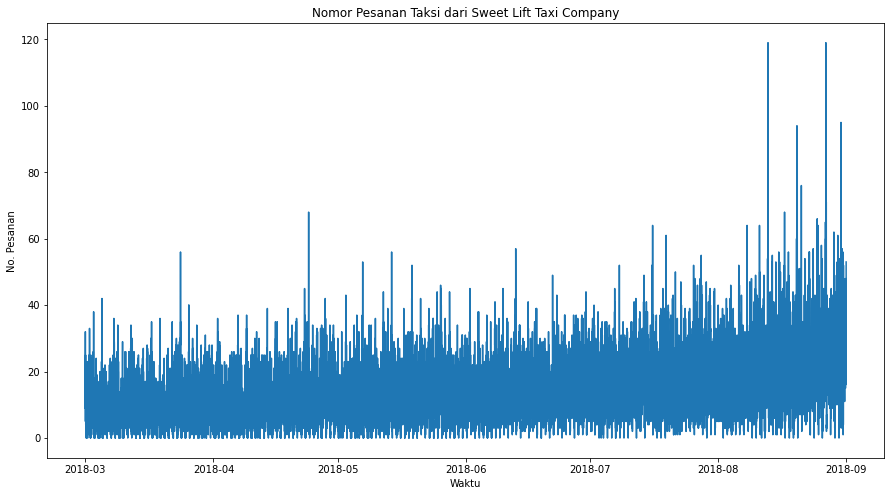

In [12]:
# menampilkan visualisasi dari time serie

ts = taxi_df['num_orders']
plt.figure(figsize=(15,8))
plt.title('Nomor Pesanan Taksi dari Sweet Lift Taxi Company')
plt.xlabel('Waktu')
plt.ylabel('No. Pesanan')
plt.plot(ts);

Plot di atas adalah plot time series jumlah pesanan taksi Sweet Lift Taxi Company antara 1 Maret 2018 hingga 31 Agustus 2018. Melihat plot tersebut, kita bisa melihat tren pada data kita. Artinya, kita dapat menggunakan deret waktu untuk memodelkan data dan menghasilkan prakiraan. Kita dapat menganalisis data menggunakan berbagai komponen deret waktu.

# Resampling dalam 1 jam 

disini kita akan mengubah interval data timeseries pada kasus kali ini dengan resampling 1 jam 

In [13]:
# resampling data 1 jam 
ts = ts.resample('1H').sum()
ts

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int32

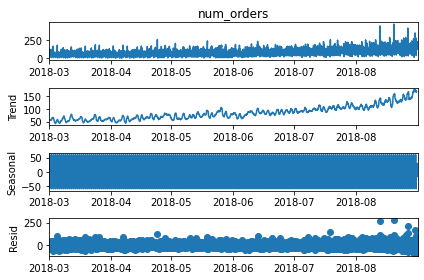

In [14]:
# visualisasi  plot interval data pada 1 jam 
resampling1H = seasonal_decompose(ts)
resampling1H.plot()
plt.show()

`Kesimpulan`  

Kita telah menyiapkan data dengan mengubah tipe data ke tipe yang tepat,  kita juga telah mengurutkan data dan memeriksa apakah diurutkan secara kronologis serta memplot visualisasi dari data yang menunjukkan jumlah pesanan berdasarkan waktu. Kami kemudian mengubah deret waktu menjadi 1 jam. Sekarang kita dapat mulai menganalisis data.

## Analisis

Pada tahap ini kita dapat mengidentifikasi tren dalam data dengan menghaluskan deret waktu dari data awal. kita akan menerapkan `rolling mean` atau `moving average` untuk mengurangi fluktuasi dalam deret waktu.

# Rolling Mean 

In [15]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    """
    seris = dataframe dengan timeseries
    window = pergerakan ukuran window
    plot_intervals = menampilkan confident interval data
    plot_anomalies = menampilkan anomali pada data
    
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Rata-rata bergerak(Moving Average)\n ukuran window = {}".format(window))
    plt.plot(rolling_mean, "g", label="Tren dari Pergerakan Rata-rata (Rolling Mean)")
    
    # Plot confidence intervals untuk mmenghaluskan deret waktu
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        
        
    # memiliki interval, temukan nilai abnormal
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plr.plot(anomalies, "ro", markersize=10)
            
        
    plt.plot(series[window:], label="Nilai yang sebenarnya")
    plt.legend(loc="upper left")
    plt.grid(True)

Jika kita menghaluskan data dengan menggunakan ukuran window 30 untuk resample menjadi `1 Hari`, kita akan memiliki plot di bawah ini. Dari plot tersebut, kita bisa melihat peningkatan jumlah taksi yang dipesan setiap hari.

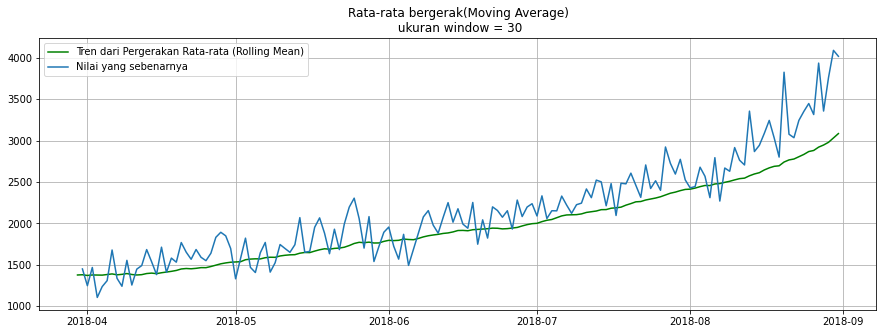

In [16]:
# plot rolling mean 
ts_ = ts.resample('1D').sum()
plotMovingAverage(ts_, 30)

Dari plot rolling mean di atas untuk ukuran jendela 30, kita dapat mengamati peningkatan yang stabil dalam jumlah pesanan dari April hingga September 2018. Plot deret waktu diatas juga  menunjukkan peningkatan tren, dimana menunjukkan peningkatan pesanan jangka panjang selama periode April hingga September 2018.

# Tren dan Musiman

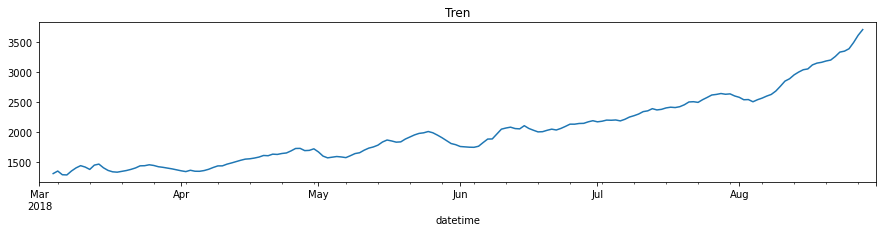

In [17]:
decomposed = seasonal_decompose(ts_)

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Tren');

Kami mengamati bahwa data menunjukkan tren naik. Dengan menggunakan garis tren, kita dapat membuat peramalan ke masa depan.

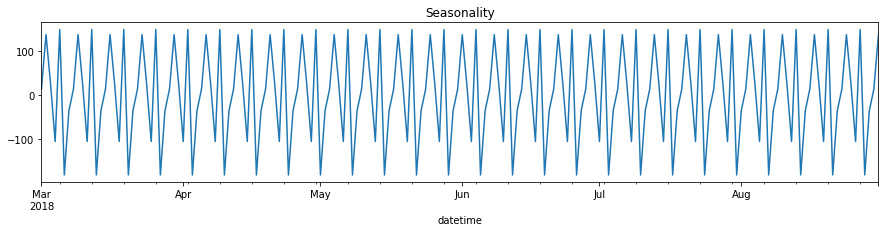

In [18]:
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Seasonality');

Plot di atas menunjukkan fluktuasi periodik dalam deret waktu dalam periode tertentu. Fluktuasi tersebut membentuk pola yang cenderung berulang dari satu periode musim ke musim berikutnya.

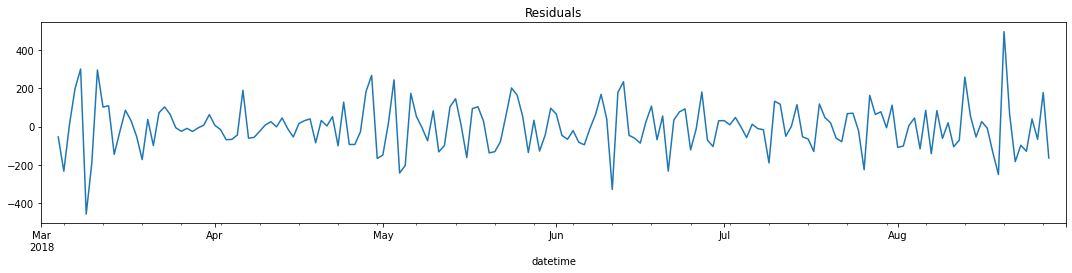

In [19]:
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Residuals')
plt.tight_layout()

Mari kita lihat perbedaan pesanan selama akhir pekan tertentu. Kita akan memplot grafik komponen musiman selama dua minggu pertama di bulan Maret 2018.

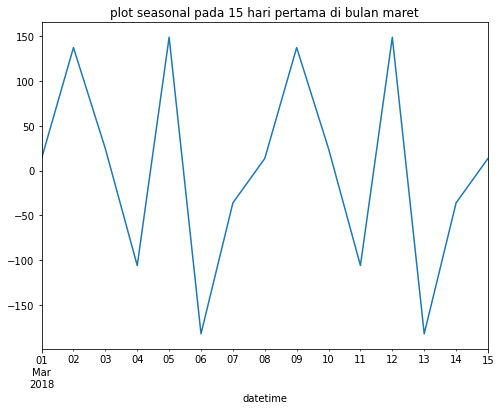

In [20]:
# plot seasonal pada 15 hari pertama di bulan maret
decomposed.seasonal['2018-03-01' : '2018-03-15'].plot(figsize=(8,6))
plt.title('plot seasonal pada 15 hari pertama di bulan maret')
plt.show()

Dari plot di atas, kita dapat mengamati Pemesanan taksi mencapai puncaknya pada tanggal 2 (Senin), 5 (Jumat), 9 (Senin), dan 12 (Jumat) Maret 2018. Pola yang dibentuk oleh fluktuasi ini berulang dari satu periode musim ke periode berikutnya.

# Autocorrelation dan Partial autocorrelation

Kita dapat menerapkan autokorelasi yanng mana merupakan korelasi antara dua nilai dalam deret waktu untuk menemukan pola dalam data kita. Kita akan menggunakan fungsi autokorelasi (ACF) untuk mengidentifikasi kelambatan (lag) mana yang memiliki korelasi signifikan, memahami pola dan properti deret waktu, lalu menggunakan informasi tersebut untuk memodelkan data deret waktu. Dari ACF, kita dapat menilai keacakan dan stasioneritas deret waktu, dan juga menentukan apakah ada tren dan pola musiman.

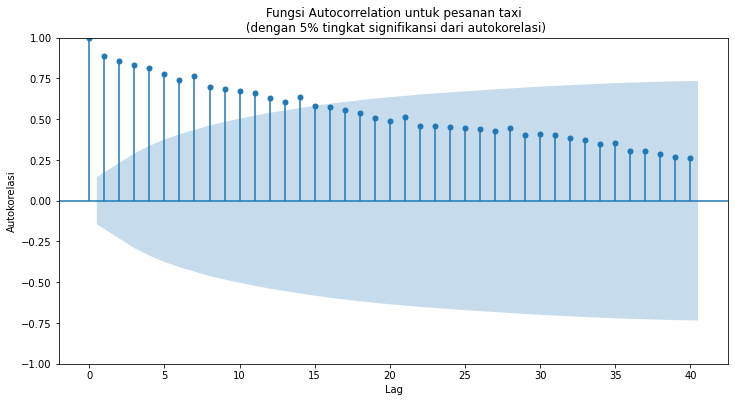

In [21]:
# plot fungsi autocorrelation 
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(ts_, lags= 40, title= 'Fungsi Autocorrelation untuk pesanan taxi\n (dengan 5% tingkat signifikansi dari autokorelasi)', ax=ax)
plt.ylabel('Autokorelasi')
plt.xlabel('Lag')
plt.show()

Dalam plot ACF, setiap batang mewakili ukuran dan arah korelasi. Kita dapat mengamati bahwa tren hadir dalam deret waktu, kelambatan yang lebih pendek biasanya memiliki korelasi positif yang besar karena pengamatan yang lebih dekat dalam waktu cenderung memiliki nilai yang sama. Korelasi meruncing perlahan saat kelambatan meningkat. Batang yang melintasi garis biru signifikan secara statistik. Dalam plot ACF untuk pesanan taksi, autokorelasi menurun secara perlahan. Lima belas kelambatan pertama sangat signifikan.

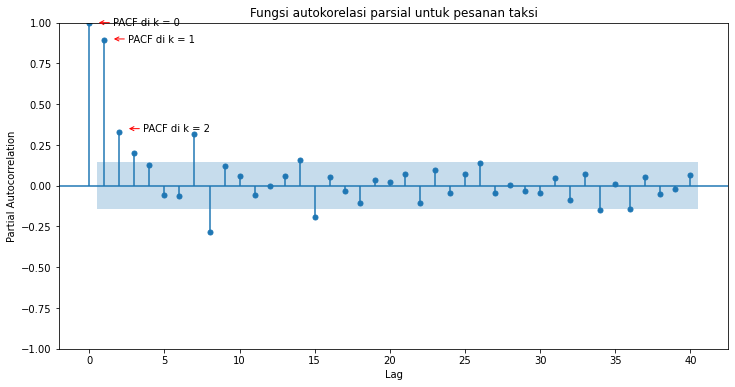

In [22]:
# plot dar partial autocorrelation function
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(ts_, lags = 40, title='Fungsi autokorelasi parsial untuk pesanan taksi', ax=ax)
# Anotasi PACF di k
ax.annotate('PACF di k = 0', 
            xy=(0.5, 1.0), 
            xycoords='data', 
            fontsize=10, 
            xytext=(50, 0),
            textcoords='offset points', 
            arrowprops=dict(arrowstyle='->', color='red'), 
            horizontalalignment='center',  
            verticalalignment='center')
ax.annotate(
    'PACF di k = 1', 
    xy=(1.5, 0.9), 
    xycoords='data', 
    fontsize=10, 
    xytext=(50, 0), 
    textcoords='offset points', 
    arrowprops=dict(arrowstyle='->', color='red'), 
    horizontalalignment='center',  
    verticalalignment='center')
ax.annotate(
    'PACF di k = 2', 
    xy=(2.5, 0.35), 
    xycoords='data', 
    fontsize=10, 
    xytext=(50, 0), 
    textcoords='offset points', 
    arrowprops=dict(arrowstyle='->', color='red'), 
    horizontalalignment='center',  
    verticalalignment='center')
plt.ylabel('Partial Autocorrelation')
plt.xlabel('Lag')
plt.show()

PACF pada Lag 0 adalah 1,0. PACF pada Lag 1 adalah 0,9. Nilai PACF pada Lag 2 adalah 0,3. Pada grafik, autokorelasi parsial untuk kelambatan 0, 1 dan 2 secara statistik signifikan. Kelambatan berikutnya hampir signifikan. Dengan menilai pola autokorelasi dan autokorelasi parsial dalam data, kita dapat memahami sifat deret waktu kita dan memodelkannya.

## Pelatihan

Pada tahap ini kita akan membuat fitur baru untuk data deret waktu. Kita dapat membuat fitur bulan, hari, hari dalam seminggu dan jam dari kolom tanggal dan waktu. Kami juga akan membuat kelambatan (lag)

In [23]:
# fungsi untuk membuat features baru
def make_features(data, max_lag, rolling_mean_size):
    data['month']     = data.index.month
    data['day']       = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour']      = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [24]:
# membuat features baru
ts = pd.DataFrame(ts)
make_features(ts,6,7)
ts.head(30)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,42.571429


In [25]:
# drop nilai NaN dari time series data
ts = ts.dropna()
print('Dataset Time Series Mempunyai', ts.shape[0], 'baris dan', ts.shape[1], 'features')
print()
ts.head(30)

Dataset Time Series Mempunyai 4409 baris dan 12 features



,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,42.571429
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,35.285714
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,35.000000
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,34.714286
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,42.285714
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,45.714286
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,48.571429
2018-03-01 15:00:00,66,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,53.285714


# Memisahkan data train dan test dari 10% data awal 

In [26]:
# Fungsi untuk mendefenisikan metric
def rmse(true, pred):
    return mean_square_error(true, pred)**0.5

In [27]:
# memisahkan data train dan test set
train, test = train_test_split(ts, shuffle=False, test_size=0.1)

In [28]:
# menampilkan index dari data set
print(train.index.min(),'sampai dengan', train.index.max())
print(test.index.min(),'sampai dengan',  test.index.max())
print()
print('Train set mempunyai', train.shape[0], 'dan baris', train.shape[1], 'features')
print('Test set mempunyai', test.shape[0], 'dan baris', test.shape[1], 'features')


2018-03-01 07:00:00 sampai dengan 2018-08-13 14:00:00
2018-08-13 15:00:00 sampai dengan 2018-08-31 23:00:00

Train set mempunyai 3968 dan baris 12 features
Test set mempunyai 441 dan baris 12 features


In [29]:
# menentukan variable untuk target dan features
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Dalam melatih dan menguji model, kita akan mencoba algoritme berikut :


1. Linear Regression
2. Random Forest Regression
3. Catboost Regressor
4. XGBoost Regressor
5. LightGBM Regressor
6. KNeighbors Regressor


Untuk menyetel hyperparameter, kami menggunakan pemisahan deret waktu untuk validasi silang

In [30]:
# memisahkan time series 
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


# Linear Regression

In [31]:
# Fungsi untuk melatih model dan membuat prediksi 
def train_linear_model(X_train, y_train):
    """fungsi ini untuk melatih regresi linear"""
    global lr_model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
def linear_regressor_pred(X_test, y_test):
    """
    Fungsi untuk membuat prediksi
    menggunakan regresi linear
    """
    
    lr_pred = lr_model.predict(X_test)
    # RMSE
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
    print("\033[1m" + 'RMSE dari Regresi Linear' + "\033[0m")
    print('RMSE: {:.3f}'.format(lr_rmse))
    print()

In [32]:
%%time
# melatih model
train_linear_model(features_train, target_train)

CPU times: user 5.2 ms, sys: 274 µs, total: 5.48 ms
Wall time: 3.99 ms


In [33]:
%%time
# membuat prediksi dan RMSE
linear_regressor_pred(features_test, target_test)

RMSE dari Regresi Linear
RMSE: 52.740

CPU times: user 2.71 ms, sys: 7.77 ms, total: 10.5 ms
Wall time: 3.41 ms


# KNeighbors Regressor

In [34]:
%%time
# optimasi hyperparameter model KNeighbors regresi

# menentukan tuning hyper parameter
knn_grid = {'n_neighbors' : range(1,5,1),
           'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
           }
# model 
knn_reg = KNeighborsRegressor()

# Grid search 
grid_search_knn = GridSearchCV(
    estimator   = knn_reg,
    param_grid  = knn_grid,
    scoring     = "neg_mean_squared_error",
    cv          = tscv, 
    n_jobs      = 1
)

# menjalankan grid search
grid_search_knn.fit(features_train, target_train)

# hasil 
print('Hyperparameter terbaik: {}'.format(grid_search_knn.best_params_))

Hyperparameter terbaik: {'algorithm': 'auto', 'n_neighbors': 4}
CPU times: user 2.13 s, sys: 1.51 s, total: 3.65 s
Wall time: 3.69 s


In [35]:
# fungsi melatih model dan prediksi 
def train_KNeighbors_regressor(X_train, y_train):
    """fungsi ini untuk melatih KNeighbors regressor model"""
    global knn_model
    # model
    knn_model = KNeighborsRegressor(**grid_search_knn.best_params_)
    knn_model.fit(X_train, y_train)
        
def KNeighbors_regressor_pred(X_test, y_test):
    """
    Fungsi untuk membuat prediksi
    menggunakan KNeighbors regression
    """
    # model
    knn_pred = knn_model.predict(X_test)
    # rmse
    knn_rmse = np.sqrt(mean_squared_error(y_test, knn_pred))
    print("\033[1m" + 'RMSE dari KNeighbors regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(knn_rmse))
    print()

In [36]:
%%time
train_KNeighbors_regressor(features_train, target_train)

CPU times: user 9.57 ms, sys: 580 µs, total: 10.1 ms
Wall time: 9.13 ms


In [37]:
%%time 
KNeighbors_regressor_pred(features_test, target_test)

RMSE dari KNeighbors regressor
RMSE: 62.147

CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 13.9 ms


# Random Forest Regressor

In [38]:
%%time
# optimasi hyperparameter model Random Forest Regressor

# menentukan tuning hyper parameter
grid = {
    "n_estimators"       : [10, 25, 50, 100],
    "max_depth"          : [None, 2, 4, 8, 10, 12],
    "min_samples_leaf"   : [2, 4, 6]
}

# model 
regressor = RandomForestRegressor(random_state = 12345)
# grid search
grid_search_rf = GridSearchCV(estimator = regressor, param_grid = grid, scoring= 'neg_mean_squared_error', cv=tscv)
# menjalankan grid search
grid_search_rf.fit(features_train, target_train)
# hasil 
print('Parameter terbaik : {}'. format(grid_search_rf.best_params_))

Parameter terbaik : {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
CPU times: user 2min 11s, sys: 320 ms, total: 2min 12s
Wall time: 2min 12s


In [39]:
# fungsi melatih model dan prediksi
def train_random_forest(X_train, y_train):
    """fungsi ini untuk melatih random forest regressor """
    global rf_model
    # model
    rf_model = RandomForestRegressor(**grid_search_rf.best_params_)
    rf_model.fit(X_train, y_train)
    
def random_forest_pred(X_test, y_test):
    """
    Fungsi untuk membuat prediksi
    menggunakan random forest regressor
    """
    # model 
    rf_pred = rf_model.predict(X_test)
    # rmse
    rf_pred = np.sqrt(mean_squared_error(y_test, rf_pred))
    print("\033[1m" + 'RMSE dari Random Forest Regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(rf_pred))
    print()
    
    # features penting dari model 
    sorted_feature_importance = rf_model.feature_importances_. argsort()
    plt.figure(figsize=(8,6))
    plt.barh(features_train.columns[sorted_feature_importance],
            rf_model.feature_importances_[sorted_feature_importance],
             color='turquoise'
            )
    plt.xlabel("Feature penting dari Random Forest ")

In [40]:
%%time
train_random_forest(features_train, target_train)

CPU times: user 2.38 s, sys: 3.94 ms, total: 2.39 s
Wall time: 2.4 s


RMSE dari Random Forest Regressor
RMSE: 44.786

CPU times: user 73.9 ms, sys: 41 µs, total: 73.9 ms
Wall time: 71.3 ms


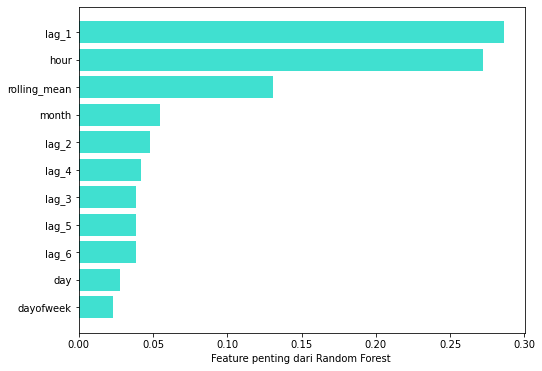

In [41]:
%%time
random_forest_pred(features_test, target_test)

# Catboost Regressor

In [42]:
%%time
# optimasi hyperparameter model catboost regressor

# menentukan tuning hyper parameter
grid= {'learning_rate'  : [0.001, 0.01, 0.5],
       'depth'          : [4, 6, 10],
       'l2_leaf_reg'    : [1, 3, 5, 7, 9]
      }

# model
cb_reg = CatBoostRegressor(
    iterations            = 500,
    logging_level          = 'Silent',
    loss_function          = 'RMSE',
    early_stopping_rounds  = 50,
    random_state           = 12345)
# Grid Search 
grid_search = GridSearchCV(estimator = cb_reg, param_grid = grid, scoring='neg_mean_squared_error', cv=tscv)
# menjalankan grid search
grid_search.fit(features_train, target_train)
# hasil
print('Parameter terbaik: {}'. format(grid_search.best_params_))

Parameter terbaik: {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
CPU times: user 12min 5s, sys: 2.58 s, total: 12min 8s
Wall time: 12min 28s


In [43]:
# fungsi melatih model dan prediksi
def train_catboost_regressor(X_train, y_train, X_test, y_test):
    """fungsi ini untuk melatih model catboost regressor"""
    global cb_model
    # model
    cb_model = CatBoostRegressor(**grid_search.best_params_)
    cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=False)
    
def catboost_regressor_pred(X_test, y_test):
    """
    Fungsi untuk membuat prediksi
    menggunakan model catboost regressor
    """
    # model
    cb_pred = cb_model.predict(X_test)
    # rmse
    cb_rmse = np.sqrt(mean_squared_error(y_test, cb_pred))
    print("\033[1m" + 'RMSE dari Catboost Regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(cb_rmse))
    print()
    
    # features penting dari model
    sorted_feature_importance = cb_model.feature_importances_.argsort()
    plt.figure(figsize=(8,6))
    plt.barh(features_train.columns[sorted_feature_importance],
            cb_model.feature_importances_[sorted_feature_importance],
            color='turquoise')
    plt.xlabel("Feature penting dari Catboost")

In [44]:
%%time
train_catboost_regressor(features_train, target_train,features_test, target_test)

CPU times: user 20.9 s, sys: 76 ms, total: 21 s
Wall time: 21.1 s


RMSE dari Catboost Regressor
RMSE: 47.622

CPU times: user 30 ms, sys: 5.47 ms, total: 35.4 ms
Wall time: 31 ms


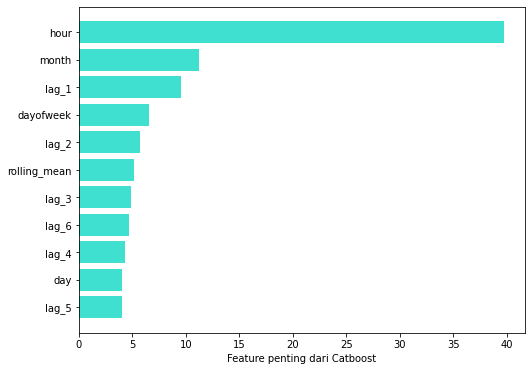

In [45]:
%%time
catboost_regressor_pred(features_test, target_test)

# XGBoost Regressor

In [50]:
%%time
# optimasi hyperparameter model xgboost

# menentukan tuning hyper parameter
xgb_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.3], 
            'max_depth': [2, 4, 6, 10],
            'n_estimators': [50, 100, 200, 500]
           }
# model 
xgb_regr = XGBRegressor(random_state = 12345)

# grid search
grid_search_xgb = GridSearchCV(
    estimator = xgb_regr, 
    param_grid = xgb_grid, 
    scoring = "neg_mean_squared_error", 
    cv = tscv, 
    n_jobs = 1
)
# menjalankan grid search
grid_search_xgb.fit(features_train, target_train)
# hasil 
print('Parameter terbaik : {}'.format(grid_search_xgb.best_params_))

Parameter terbaik : {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
CPU times: user 13min 45s, sys: 7.25 s, total: 13min 52s
Wall time: 13min 59s


In [51]:
# fungsi melatih model dan prediksi
def train_xgboost_reg(X_train, y_train):
    """fungsi ini untuk melatih model XGBoost """
    global xgb_model
    # model
    xgb_model = XGBRegressor(**grid_search_xgb.best_params_)
    xgb_model.fit(X_train, y_train) 
    
def xgboost_regressor_pred(X_test, y_test):
    """
    Fungsi untuk membuat prediksi
    menggunakan model XGBoost
    """
    # model
    xgb_pred = xgb_model.predict(X_test)
    # rmse
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    print("\033[1m" + 'RMSE dari XGBoost Regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(xgb_rmse))
    print()
    
    # features penting dari model 
    sorted_feature_importance = xgb_model.feature_importances_.argsort()
    plt.figure(figsize=(8,6))
    plt.barh(features_train.columns[sorted_feature_importance], 
             xgb_model.feature_importances_[sorted_feature_importance], 
             color='turquoise')
    plt.xlabel("Feature penting dari XGBoost")

In [52]:
%%time
train_xgboost_reg(features_train, target_train)

CPU times: user 1.19 s, sys: 12.2 ms, total: 1.2 s
Wall time: 1.21 s


RMSE dari XGBoost Regressor
RMSE: 45.933

CPU times: user 39.8 ms, sys: 33 µs, total: 39.8 ms
Wall time: 33.1 ms


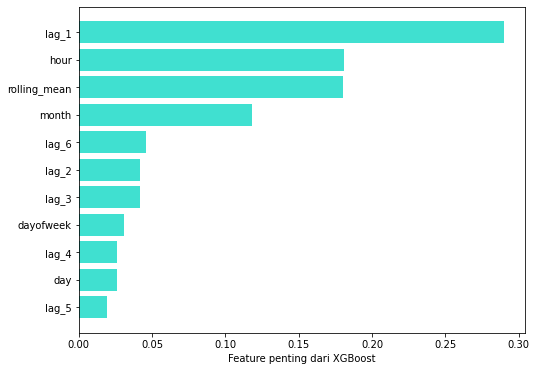

In [53]:
%%time
xgboost_regressor_pred(features_test, target_test)

# LightGBM Regressor

In [46]:
%%time
# optimasi hyperparameter model xgboost

# menentukan tuning hyper parameter
lgbm_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
             'n_estimators': [50, 100, 500],
             'num_leaves': [5, 10, 20, 31]
            }

# model 
lgbm_regr = LGBMRegressor(random_state = 12345)

# grid search
grid_search_lgbm = GridSearchCV(
    estimator = lgbm_regr, 
    param_grid = lgbm_grid, 
    scoring = "neg_mean_squared_error", 
    cv = tscv, 
    n_jobs = 1
)

# menjalankan grid search
grid_search_lgbm.fit(features_train, target_train)
# hasil 
print('Parameter terbaik : {}'.format(grid_search_lgbm.best_params_))

Parameter terbaik : {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31}
CPU times: user 1min 40s, sys: 1.99 s, total: 1min 42s
Wall time: 1min 43s


In [47]:
# fungsi melatih model dan prediksi
def train_lightGBM_reg(X_train, y_train):
    """fungsi ini untuk melatih model LightGBM regressor"""
    global lgbm_model
    # model
    lgbm_model = LGBMRegressor(**grid_search_lgbm.best_params_)
    lgbm_model.fit(X_train, y_train) 
    
def lightGBM_regressor_pred(X_test, y_test):
    """
    Fungsi untuk membuat prediksi
    menggunakan model lightGBM regression 
    """
    # model
    lgbm_pred = lgbm_model.predict(X_test)
    # rmse
    lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
    print("\033[1m" + 'RMSE dari LightGBM Regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(lgbm_rmse))
    print()
    
    # features penting dari model  
    sorted_feature_importance = lgbm_model.feature_importances_.argsort()
    plt.figure(figsize=(8,6))
    plt.barh(features_train.columns[sorted_feature_importance], 
             lgbm_model.feature_importances_[sorted_feature_importance], 
             color='turquoise')
    plt.xlabel("Feature penting dari LightGBM ")

In [48]:
%%time
train_lightGBM_reg(features_train, target_train)

CPU times: user 1.9 s, sys: 39.3 ms, total: 1.94 s
Wall time: 1.92 s


RMSE dari LightGBM Regressor
RMSE: 45.342

CPU times: user 58.1 ms, sys: 0 ns, total: 58.1 ms
Wall time: 100 ms


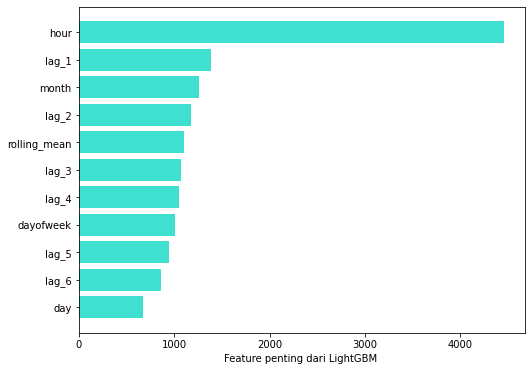

In [49]:
%%time
lightGBM_regressor_pred(features_test, target_test)

# Hasil Model 

Pada bagian ini, kita akan menganalisis kecepatan dan kualitas model yang dilatih. Ringkasan model, RMSE masing-masing, waktu yang diperlukan untuk menyetel hyperparameter, dan melatih model ditampilkan di bawah.

In [60]:
Model_analyz = {"Model" : ["Linear Regression", "KNeighbors Regressor", "Random Forest Regressor", "Catboost Regressor", "XGBoost Regressor", "LightGBM Regressor"], "Hyperparamater Tune":['0', '3.69s', '2min 12s','12min 28s','13min 59s','1min 43s'] , "Training time" :  ['3.99 ms','9.13 ms','2.4 s','21.1 s','1.21 s','1.92 s'] , "Predict time" : ['3.41 m','13.9 ms','71.3 ms','31 ms','33.1 ms','100 ms']   , "RMSE" :  ['52.740', '62.147','44.786','47.622','45.933','45.342']}

In [61]:
pd.DataFrame(Model_analyz)

,Model,Hyperparamater Tune,Training time,Predict time,RMSE
0,Linear Regression,0,3.99 ms,3.41 m,52.740
1,KNeighbors Regressor,3.69s,9.13 ms,13.9 ms,62.147
2,Random Forest Regressor,2min 12s,2.4 s,71.3 ms,44.786
3,Catboost Regressor,12min 28s,21.1 s,31 ms,47.622
4,XGBoost Regressor,13min 59s,1.21 s,33.1 ms,45.933
5,LightGBM Regressor,1min 43s,1.92 s,100 ms,45.342


Kesimpulan :

Pada tahap ini kita melatih berbagai algoritme dengan berbagai hyperparameter, yakni :  Linear regressor, KNeighbors regressor, Random forest regressor, Catboost regressor, XGBoost regressor dan LightGBM regressor. kita juga menyetel berbagai hyperparameter yang memengaruhi kinerja model serta mengamati waktu yang diperlukan untuk menyetel hyperparameter, waktu latih dan waktu prediksi model. Metrik yang digunakan untuk mengevaluasi model adalah RMSE Score. Algoritma KNeighbors regressor memiliki waktu pelatihan tercepat namun memiliki skor RMSE terburuk yaitu 62,147 dan Random Forest Regressor memiliki waktu penyetelan tercepat yakni 44.786. Model dengan skor RMSE terbaik akan dipilih untuk pengujian model untuk tugas ini.

## Pengujian

Random Forest Regressor dipilih sebagai model untuk pengujian akhir untuk tugas ini karena memiliki skor RMSE terbaik. 

RMSE dari Random Forest Regressor
RMSE: 44.786



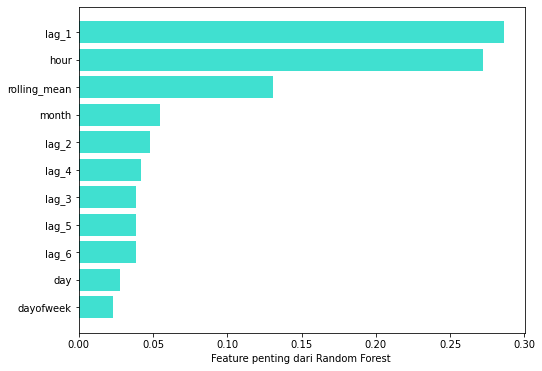

In [63]:
# menguji model 
random_forest_pred(features_test, target_test)

Kesimpulan:
___
Menggunakan algoritma Random Forest Regressor, kita memperoleh skor RMSE: 44.786 untuk test dataset. dapat dilihat bahwa Feature penting yang di tampilkan dari algoritma Random Forest Regressor yakni :  `lag_1`, `hour`, `rolling_mean`, `month`dan `lag_2`. `dayofweek` adalah feature yang paling tidak penting untuk model ini. 


# Daftar Periksa Penilaian

- [x]  Jupyter Notebook bisa dibuka.
- [ ]  Tidak ada kesalahan dalam kode
- [ ]  Sel-sel dengan kode telah disusun berdasarkan urutan eksekusi.
- [ ]  Data telah diunduh dan disiapkan
- [ ]  Data telah dianalisis
- [ ]  Model sudah dilatih dan hiperparameter sudah dipilih
- [ ]  Model sudah dievaluasi. Kesimpulan sudah ada.
- [ ] *RMSE* untuk *test set* tidak lebih dari 48